In [3]:
import numpy as np
from openeye import oeomega  # Omega toolkit
omega = oeomega.OEOmega()
omega.SetMaxConfs(800)  # Best-practice? Expensive...
omega.SetIncludeInput(False)
omega.SetStrictStereo(True)  # Refuse to generate conformers if stereochemistry not provided

from openforcefield.typing.engines.smirnoff import ForceField, generateTopologyFromOEMol
from openeye import oechem  # OpenEye Python toolkits

from openeye import oequacpac  # Charge toolkit

ff = ForceField('forcefield/smirnoff99Frosst.offxml')

def generate_oemol(smiles):
    """Add hydrogens, assign charges, generate conformers, and return molecule"""
    mol = oechem.OEMol()
    chargeEngine = oequacpac.OEAM1BCCCharges()
    oechem.OEParseSmiles(mol, smiles)
    oechem.OEAddExplicitHydrogens(mol)
    status = omega(mol)
    if not status: print("Something went wrong in `generate_oemol({})!".format(smiles))
    oechem.OETriposAtomNames(mol)
    oequacpac.OESetNeutralpHModel(mol)
    oequacpac.OEAssignCharges(mol, chargeEngine)
    _ = generateTopologyFromOEMol(mol)
    return mol


def generate_mol_top_sys_pos(smiles):
    """Generate an openmm topology, openmm system, and coordinate array from a smiles string"""
    print(smiles)
    mol = generate_oemol(smiles)

    coord_dict = mol.GetCoords()
    positions = np.array([coord_dict[key] for key in coord_dict])

    topology = generateTopologyFromOEMol(mol)

    system = ff.createSystem(topology, [mol])

    return mol, topology, system, positions

In [4]:
mol, topology, system, positions = generate_mol_top_sys_pos('C1[C@@H]2[C@H]3[C@@H]([C@H]1[C@H]4[C@@H]2O4)[C@@]5(C(=C([C@]3(C5(Cl)Cl)Cl)Cl)Cl)Cl')

C1[C@@H]2[C@H]3[C@@H]([C@H]1[C@H]4[C@@H]2O4)[C@@]5(C(=C([C@]3(C5(Cl)Cl)Cl)Cl)Cl)Cl


In [5]:
len(positions)

27

In [6]:
from simtk.openmm import app
from simtk import openmm as mm
from simtk import unit

vacuum_sim = app.Simulation(topology,
                     system,
                     mm.LangevinIntegrator(298 * unit.kelvin, 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                     platform=mm.Platform.getPlatformByName('Reference')
                    )
vacuum_sim.context.setPositions(positions)
vacuum_sim.context.setVelocitiesToTemperature(298 * unit.kelvin)
vacuum_sim.step(1)

In [7]:
vacuum_sim.step(1000)

In [8]:
from tqdm import tqdm
vacuum_traj = []

for _ in tqdm(range(100)):
    vacuum_sim.step(1000)
    vacuum_traj.append(vacuum_sim.context.getState(getPositions=True).getPositions(asNumpy=True))

100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


In [9]:
system.getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x128e74e40> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x128e742d0> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x128e74630> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x128e747b0> >,
 <simtk.openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x128e74510> >]

In [10]:
from openmmtools.constants import kB
kT = kB * 298 * unit.kelvin

u = np.zeros(len(vacuum_traj))

for i in range(len(vacuum_traj)):
    vacuum_sim.context.setPositions(vacuum_traj[i])
    u[i] = vacuum_sim.context.getState(getEnergy=True).getPotentialEnergy() / kT

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

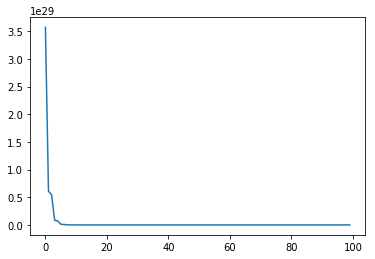

In [17]:
plt.plot(u)

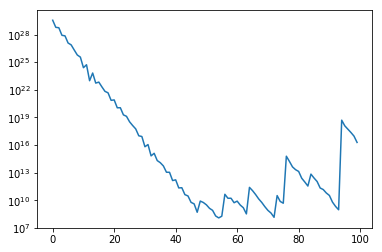

In [14]:
plt.plot(u)
plt.yscale('log')

In [15]:
# oh shoot! must make sure to minimize first...

from simtk.openmm import app
from simtk import openmm as mm
from simtk import unit

vacuum_sim = app.Simulation(topology,
                     system,
                     mm.LangevinIntegrator(298 * unit.kelvin, 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                     platform=mm.Platform.getPlatformByName('Reference')
                    )
vacuum_sim.context.setPositions(positions)
vacuum_sim.context.setVelocitiesToTemperature(298 * unit.kelvin)
vacuum_sim.minimizeEnergy()
vacuum_sim.step(1)

In [16]:
vacuum_traj = []

for _ in tqdm(range(100)):
    vacuum_sim.step(1000)
    vacuum_traj.append(vacuum_sim.context.getState(getPositions=True).getPositions(asNumpy=True))

100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


In [18]:
u = np.zeros(len(vacuum_traj))

for i in range(len(vacuum_traj)):
    vacuum_sim.context.setPositions(vacuum_traj[i])
    u[i] = vacuum_sim.context.getState(getEnergy=True).getPotentialEnergy() / kT

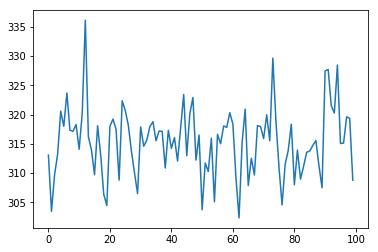

In [19]:
plt.plot(u)

In [22]:
import mdtraj as md
traj = md.Trajectory(xyz=np.array([pos.value_in_unit(unit.nanometer) for pos in vacuum_traj]),
              topology=md.Topology().from_openmm(topology))

In [23]:
path = "/Users/joshuafass/Documents/MSKCC/Chodera Lab/feedstock/FreeSolv-0.51/database.txt"
from pickle import load
with open(path, 'r') as f:
    freesolv = f.read()
from tqdm import tqdm

db = []
for entry in freesolv.split('\n')[3:-1]:
    db.append(entry.split('; '))
    
smiles_list = [entry[1] for entry in db]

db[np.argmax(list(map(len, smiles_list)))]

['mobley_8117218',
 'C1[C@@H]2[C@H]3[C@@H]([C@H]1[C@H]4[C@@H]2O4)[C@@]5(C(=C([C@]3(C5(Cl)Cl)Cl)Cl)Cl)Cl',
 'endrin',
 '-4.82',
 '0.10',
 '-5.18',
 '0.04',
 '10.1021/jp806724u',
 '10.1021/jp806838b',
 'Experimental uncertainty not presently available, so assigned a default value.  ']

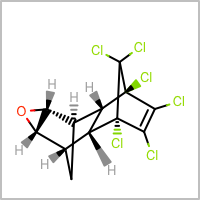

In [24]:
import oenotebook as oenb
oenb.draw_smiles('C1[C@@H]2[C@H]3[C@@H]([C@H]1[C@H]4[C@@H]2O4)[C@@]5(C(=C([C@]3(C5(Cl)Cl)Cl)Cl)Cl)Cl')

In [26]:
traj = traj.superpose(traj)

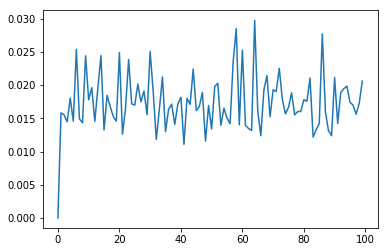

In [28]:
plt.plot(md.rmsd(traj, traj))

In [30]:
traj.save_pdb('endrin_vacuum_samples.pdb')